# Actor Critic for Cartpole

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.distributions import Categorical

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import gym

### Cartpole environment

In [2]:
env = gym.make('CartPole-v1')

In [3]:
def compute_mov_avg(data: list, window=10):
    ids = [window * x for x in range(0, int(len(data) / window) + 1)]
    if ids[-1] < len(data) - 1:
        ids.append(len(data) - 1)
    mov_avg = []
    for i in range(1, len(ids)):
        mov_avg.append(sum(data[ids[i - 1]:ids[i]]) / len(data[ids[i - 1]:ids[i]]))
    return ids[1:], mov_avg

def display_metrics(data: list, legend: str, mov_avg=50):
    plt.figure(figsize=(15,5))
    # Plot data
    plt.plot(np.arange(len(data)), data, label=legend)
    # Plot moving average
    if len(data) > 5 * mov_avg:
        ids, avg = compute_mov_avg(data, mov_avg)
        plt.plot(ids, avg, label=legend + ' average')
    plt.legend()
    plt.show()

### Undistributed Proximal Policy Optimisation

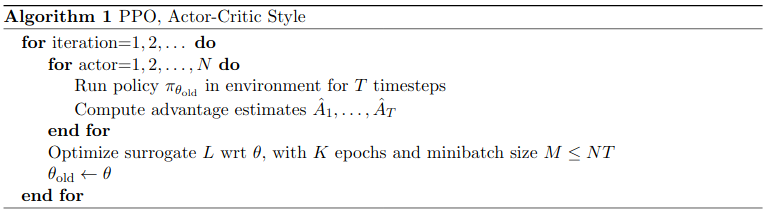

In [4]:
from IPython.display import Image
Image(filename="img/ppo-algo.png")

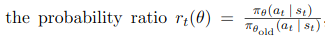

In [5]:
Image(filename="img/probability-ratio.png")

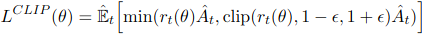

In [6]:
Image(filename="img/lclip.png")

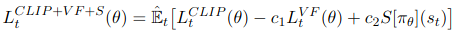

In [7]:
Image(filename="img/ppo-complete-loss.png")

In [32]:
class AdvantageActorCritic(nn.Module):
    
    def __init__(self):
        super(AdvantageActorCritic, self).__init__()
        
        # Common network
        self.fc1 = nn.Linear(in_features=4, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=2)
        
        # Actor head: outputs probability distribution of actions
        self.actor_head = nn.Linear(in_features=2, out_features=2)
        
        # Critic head: outputs value of state
        self.critic_head = nn.Linear(in_features=2, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        policy = F.softmax(self.actor_head(x))
        value = self.critic_head(x)
        return policy, value
    
class PPO_Agent():
    
    def __init__(self, env, lr=0.01, dr=0.95, eps=0.2):
        # Cartpole environment
        self.cartpole_env = env
        
        # Learning rates
        self.lr = lr
        # Discount rate
        self.dr = dr
        # Clipping hyperparameter
        self.eps = eps
        
        # Actor Critic model
        self.model = AdvantageActorCritic()
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        
        # Saving training curves
        self.rewards = []
        self.losses = []
        
    def choose_action(self, state):
        # Translate state to fit model input
        state = torch.from_numpy(state).float().unsqueeze(0)
        # Get actions probability distribution
        probs, _ = self.model(state)
        distrib = Categorical(probs)
        # Sample action
        action = distrib.sample()
        return action.item(), probs[0, action]
    
    def clip(self, r):
        if r < 1 - self.eps:
            return torch.Tensor([1 - self.eps])
        elif r > 1 + self.eps:
            return torch.Tensor([1 + self.eps])
        else:
            return r
    
    def compute_loss(self, state, action, action_prob, reward, next_state, done, G=None):
        # Get policy and value of state
        state = torch.from_numpy(state).float().unsqueeze(0)
        policy, value = self.model(state)
        # Compute Q-target
        if not done:
            if G is None:
                # Get value of next_state
                next_state = torch.from_numpy(next_state).float().unsqueeze(0)
                _, next_value = self.model(next_state)
                # Compute q_target
                q_target = torch.Tensor([reward]) + self.dr * next_value
            else:
                q_target = G
        else:
            q_target = torch.Tensor([reward])
        # Compute Advantage
        advantage = q_target - value
        # Compute Actor's Loss
        prob_ratio = policy[0, action] / action_prob
        L_actor = torch.min(prob_ratio * advantage, 
                            torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps) * advantage)
        # Compute Critic's loss
        L_critic = (q_target - value) ** 2
        # Return complete loss
        return L_critic - L_actor
        
    def train(self, nb_episodes=1000, nb_iter=8, nb_epochs=20, complete_return=False):
        for i in range(nb_episodes):
            experiences = []
            print(f"Episode #{i}")
            for n in range(nb_iter):
                state = env.reset()
                trajectory = []
                for t in range(500):
                    env.render()
                    # Choose action
                    action, action_prob = self.choose_action(state)
                    # Perform Action
                    next_state, reward, done, info = env.step(action)
                    # Store experience
                    trajectory.append((state, action, float(action_prob), reward, next_state, done)) 
                    # Check for end state
                    if done:
                        print("\t Iteration #{} finished after {} timesteps.".format(n + 1, t + 1))
                        self.rewards.append(t + 1)
                        break

                    state = next_state
                    
                experiences.append(trajectory)
        
            # Training
            for k in range(nb_epochs):
                for trajectory in experiences:
                    loss = []
                    for t in range(len(trajectory)):
                        if complete_return:
                            # Compute return
                            G = 0.0
                            for j in range(t, len(trajectory)):
                                G += trajectory[j][3] * self.dr ** j
                        else:
                            G = None
                        state, action, action_prob, reward, next_state, done = trajectory[t]
                        loss.append(self.compute_loss(state, action, action_prob, reward, next_state, done, G))
                
                    # Learning step
                    self.optim.zero_grad()
                    loss = torch.cat(loss).sum()
                    #print(f"\tTraining iteration #{k}: loss={loss}")
                    self.losses.append(float(loss))
                    loss.backward()
                    self.optim.step()
            
        self.cartpole_env.close()

In [33]:
ppo_agent = PPO_Agent(env)
ppo_agent.train(complete_return=True)

Episode #0
	 Iteration #1 finished after 10 timesteps.


<ipython-input-32-d8a46ac7d806>:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  policy = F.softmax(self.actor_head(x))


	 Iteration #2 finished after 22 timesteps.
	 Iteration #3 finished after 15 timesteps.
	 Iteration #4 finished after 13 timesteps.
	 Iteration #5 finished after 28 timesteps.
	 Iteration #6 finished after 10 timesteps.
	 Iteration #7 finished after 17 timesteps.
	 Iteration #8 finished after 18 timesteps.
Episode #1
	 Iteration #1 finished after 27 timesteps.
	 Iteration #2 finished after 12 timesteps.
	 Iteration #3 finished after 26 timesteps.
	 Iteration #4 finished after 11 timesteps.
	 Iteration #5 finished after 27 timesteps.
	 Iteration #6 finished after 14 timesteps.
	 Iteration #7 finished after 14 timesteps.
	 Iteration #8 finished after 13 timesteps.
Episode #2
	 Iteration #1 finished after 17 timesteps.
	 Iteration #2 finished after 9 timesteps.
	 Iteration #3 finished after 11 timesteps.
	 Iteration #4 finished after 14 timesteps.
	 Iteration #5 finished after 30 timesteps.
	 Iteration #6 finished after 15 timesteps.
	 Iteration #7 finished after 15 timesteps.
	 Iteration

	 Iteration #7 finished after 35 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #23
	 Iteration #1 finished after 15 timesteps.
	 Iteration #2 finished after 29 timesteps.
	 Iteration #3 finished after 27 timesteps.
	 Iteration #4 finished after 11 timesteps.
	 Iteration #5 finished after 47 timesteps.
	 Iteration #6 finished after 34 timesteps.
	 Iteration #7 finished after 15 timesteps.
	 Iteration #8 finished after 14 timesteps.
Episode #24
	 Iteration #1 finished after 10 timesteps.
	 Iteration #2 finished after 10 timesteps.
	 Iteration #3 finished after 9 timesteps.
	 Iteration #4 finished after 19 timesteps.
	 Iteration #5 finished after 12 timesteps.
	 Iteration #6 finished after 15 timesteps.
	 Iteration #7 finished after 20 timesteps.
	 Iteration #8 finished after 25 timesteps.
Episode #25
	 Iteration #1 finished after 34 timesteps.
	 Iteration #2 finished after 29 timesteps.
	 Iteration #3 finished after 16 timesteps.
	 Iteration #4 finished after 26 timestep

	 Iteration #4 finished after 18 timesteps.
	 Iteration #5 finished after 9 timesteps.
	 Iteration #6 finished after 21 timesteps.
	 Iteration #7 finished after 55 timesteps.
	 Iteration #8 finished after 11 timesteps.
Episode #46
	 Iteration #1 finished after 22 timesteps.
	 Iteration #2 finished after 27 timesteps.
	 Iteration #3 finished after 21 timesteps.
	 Iteration #4 finished after 11 timesteps.
	 Iteration #5 finished after 22 timesteps.
	 Iteration #6 finished after 18 timesteps.
	 Iteration #7 finished after 37 timesteps.
	 Iteration #8 finished after 32 timesteps.
Episode #47
	 Iteration #1 finished after 12 timesteps.
	 Iteration #2 finished after 22 timesteps.
	 Iteration #3 finished after 20 timesteps.
	 Iteration #4 finished after 20 timesteps.
	 Iteration #5 finished after 13 timesteps.
	 Iteration #6 finished after 12 timesteps.
	 Iteration #7 finished after 19 timesteps.
	 Iteration #8 finished after 11 timesteps.
Episode #48
	 Iteration #1 finished after 22 timestep

Episode #68
	 Iteration #1 finished after 22 timesteps.
	 Iteration #2 finished after 19 timesteps.
	 Iteration #3 finished after 12 timesteps.
	 Iteration #4 finished after 20 timesteps.
	 Iteration #5 finished after 27 timesteps.
	 Iteration #6 finished after 10 timesteps.
	 Iteration #7 finished after 17 timesteps.
	 Iteration #8 finished after 29 timesteps.
Episode #69
	 Iteration #1 finished after 30 timesteps.
	 Iteration #2 finished after 24 timesteps.
	 Iteration #3 finished after 17 timesteps.
	 Iteration #4 finished after 11 timesteps.
	 Iteration #5 finished after 26 timesteps.
	 Iteration #6 finished after 41 timesteps.
	 Iteration #7 finished after 23 timesteps.
	 Iteration #8 finished after 34 timesteps.
Episode #70
	 Iteration #1 finished after 15 timesteps.
	 Iteration #2 finished after 13 timesteps.
	 Iteration #3 finished after 23 timesteps.
	 Iteration #4 finished after 21 timesteps.
	 Iteration #5 finished after 19 timesteps.
	 Iteration #6 finished after 20 timeste

	 Iteration #7 finished after 14 timesteps.
	 Iteration #8 finished after 41 timesteps.
Episode #91
	 Iteration #1 finished after 17 timesteps.
	 Iteration #2 finished after 10 timesteps.
	 Iteration #3 finished after 17 timesteps.
	 Iteration #4 finished after 67 timesteps.
	 Iteration #5 finished after 49 timesteps.
	 Iteration #6 finished after 15 timesteps.
	 Iteration #7 finished after 30 timesteps.
	 Iteration #8 finished after 62 timesteps.
Episode #92
	 Iteration #1 finished after 33 timesteps.
	 Iteration #2 finished after 59 timesteps.
	 Iteration #3 finished after 24 timesteps.
	 Iteration #4 finished after 19 timesteps.
	 Iteration #5 finished after 26 timesteps.
	 Iteration #6 finished after 67 timesteps.
	 Iteration #7 finished after 41 timesteps.
	 Iteration #8 finished after 44 timesteps.
Episode #93
	 Iteration #1 finished after 36 timesteps.
	 Iteration #2 finished after 13 timesteps.
	 Iteration #3 finished after 48 timesteps.
	 Iteration #4 finished after 57 timeste

	 Iteration #3 finished after 13 timesteps.
	 Iteration #4 finished after 12 timesteps.
	 Iteration #5 finished after 47 timesteps.
	 Iteration #6 finished after 11 timesteps.
	 Iteration #7 finished after 31 timesteps.
	 Iteration #8 finished after 11 timesteps.
Episode #114
	 Iteration #1 finished after 12 timesteps.
	 Iteration #2 finished after 56 timesteps.
	 Iteration #3 finished after 51 timesteps.
	 Iteration #4 finished after 12 timesteps.
	 Iteration #5 finished after 35 timesteps.
	 Iteration #6 finished after 57 timesteps.
	 Iteration #7 finished after 33 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #115
	 Iteration #1 finished after 25 timesteps.
	 Iteration #2 finished after 25 timesteps.
	 Iteration #3 finished after 30 timesteps.
	 Iteration #4 finished after 27 timesteps.
	 Iteration #5 finished after 36 timesteps.
	 Iteration #6 finished after 20 timesteps.
	 Iteration #7 finished after 23 timesteps.
	 Iteration #8 finished after 25 timesteps.
Episod

	 Iteration #7 finished after 22 timesteps.
	 Iteration #8 finished after 45 timesteps.
Episode #136
	 Iteration #1 finished after 31 timesteps.
	 Iteration #2 finished after 31 timesteps.
	 Iteration #3 finished after 50 timesteps.
	 Iteration #4 finished after 13 timesteps.
	 Iteration #5 finished after 36 timesteps.
	 Iteration #6 finished after 33 timesteps.
	 Iteration #7 finished after 32 timesteps.
	 Iteration #8 finished after 45 timesteps.
Episode #137
	 Iteration #1 finished after 19 timesteps.
	 Iteration #2 finished after 24 timesteps.
	 Iteration #3 finished after 37 timesteps.
	 Iteration #4 finished after 24 timesteps.
	 Iteration #5 finished after 12 timesteps.
	 Iteration #6 finished after 23 timesteps.
	 Iteration #7 finished after 16 timesteps.
	 Iteration #8 finished after 13 timesteps.
Episode #138
	 Iteration #1 finished after 25 timesteps.
	 Iteration #2 finished after 26 timesteps.
	 Iteration #3 finished after 25 timesteps.
	 Iteration #4 finished after 33 time

	 Iteration #3 finished after 38 timesteps.
	 Iteration #4 finished after 25 timesteps.
	 Iteration #5 finished after 15 timesteps.
	 Iteration #6 finished after 9 timesteps.
	 Iteration #7 finished after 10 timesteps.
	 Iteration #8 finished after 8 timesteps.
Episode #159
	 Iteration #1 finished after 10 timesteps.
	 Iteration #2 finished after 10 timesteps.
	 Iteration #3 finished after 26 timesteps.
	 Iteration #4 finished after 9 timesteps.
	 Iteration #5 finished after 25 timesteps.
	 Iteration #6 finished after 9 timesteps.
	 Iteration #7 finished after 19 timesteps.
	 Iteration #8 finished after 26 timesteps.
Episode #160
	 Iteration #1 finished after 21 timesteps.
	 Iteration #2 finished after 21 timesteps.
	 Iteration #3 finished after 50 timesteps.
	 Iteration #4 finished after 22 timesteps.
	 Iteration #5 finished after 26 timesteps.
	 Iteration #6 finished after 25 timesteps.
	 Iteration #7 finished after 22 timesteps.
	 Iteration #8 finished after 44 timesteps.
Episode #1

	 Iteration #7 finished after 20 timesteps.
	 Iteration #8 finished after 20 timesteps.
Episode #181
	 Iteration #1 finished after 40 timesteps.
	 Iteration #2 finished after 23 timesteps.
	 Iteration #3 finished after 20 timesteps.
	 Iteration #4 finished after 19 timesteps.
	 Iteration #5 finished after 38 timesteps.
	 Iteration #6 finished after 19 timesteps.
	 Iteration #7 finished after 51 timesteps.
	 Iteration #8 finished after 47 timesteps.
Episode #182
	 Iteration #1 finished after 36 timesteps.
	 Iteration #2 finished after 27 timesteps.
	 Iteration #3 finished after 21 timesteps.
	 Iteration #4 finished after 43 timesteps.
	 Iteration #5 finished after 23 timesteps.
	 Iteration #6 finished after 20 timesteps.
	 Iteration #7 finished after 23 timesteps.
	 Iteration #8 finished after 24 timesteps.
Episode #183
	 Iteration #1 finished after 27 timesteps.
	 Iteration #2 finished after 26 timesteps.
	 Iteration #3 finished after 47 timesteps.
	 Iteration #4 finished after 36 time

	 Iteration #3 finished after 25 timesteps.
	 Iteration #4 finished after 24 timesteps.
	 Iteration #5 finished after 23 timesteps.
	 Iteration #6 finished after 11 timesteps.
	 Iteration #7 finished after 26 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #204
	 Iteration #1 finished after 33 timesteps.
	 Iteration #2 finished after 26 timesteps.
	 Iteration #3 finished after 29 timesteps.
	 Iteration #4 finished after 24 timesteps.
	 Iteration #5 finished after 25 timesteps.
	 Iteration #6 finished after 21 timesteps.
	 Iteration #7 finished after 26 timesteps.
	 Iteration #8 finished after 25 timesteps.
Episode #205
	 Iteration #1 finished after 22 timesteps.
	 Iteration #2 finished after 13 timesteps.
	 Iteration #3 finished after 25 timesteps.
	 Iteration #4 finished after 27 timesteps.
	 Iteration #5 finished after 26 timesteps.
	 Iteration #6 finished after 29 timesteps.
	 Iteration #7 finished after 26 timesteps.
	 Iteration #8 finished after 29 timesteps.
Episod

	 Iteration #7 finished after 19 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #226
	 Iteration #1 finished after 24 timesteps.
	 Iteration #2 finished after 10 timesteps.
	 Iteration #3 finished after 22 timesteps.
	 Iteration #4 finished after 25 timesteps.
	 Iteration #5 finished after 25 timesteps.
	 Iteration #6 finished after 16 timesteps.
	 Iteration #7 finished after 10 timesteps.
	 Iteration #8 finished after 15 timesteps.
Episode #227
	 Iteration #1 finished after 26 timesteps.
	 Iteration #2 finished after 10 timesteps.
	 Iteration #3 finished after 11 timesteps.
	 Iteration #4 finished after 26 timesteps.
	 Iteration #5 finished after 12 timesteps.
	 Iteration #6 finished after 29 timesteps.
	 Iteration #7 finished after 10 timesteps.
	 Iteration #8 finished after 10 timesteps.
Episode #228
	 Iteration #1 finished after 13 timesteps.
	 Iteration #2 finished after 11 timesteps.
	 Iteration #3 finished after 12 timesteps.
	 Iteration #4 finished after 12 time

	 Iteration #3 finished after 26 timesteps.
	 Iteration #4 finished after 29 timesteps.
	 Iteration #5 finished after 24 timesteps.
	 Iteration #6 finished after 26 timesteps.
	 Iteration #7 finished after 12 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #249
	 Iteration #1 finished after 22 timesteps.
	 Iteration #2 finished after 16 timesteps.
	 Iteration #3 finished after 27 timesteps.
	 Iteration #4 finished after 26 timesteps.
	 Iteration #5 finished after 23 timesteps.
	 Iteration #6 finished after 28 timesteps.
	 Iteration #7 finished after 27 timesteps.
	 Iteration #8 finished after 23 timesteps.
Episode #250
	 Iteration #1 finished after 23 timesteps.
	 Iteration #2 finished after 22 timesteps.
	 Iteration #3 finished after 18 timesteps.
	 Iteration #4 finished after 21 timesteps.
	 Iteration #5 finished after 20 timesteps.
	 Iteration #6 finished after 24 timesteps.
	 Iteration #7 finished after 26 timesteps.
	 Iteration #8 finished after 27 timesteps.
Episod

	 Iteration #7 finished after 26 timesteps.
	 Iteration #8 finished after 21 timesteps.
Episode #271
	 Iteration #1 finished after 25 timesteps.
	 Iteration #2 finished after 31 timesteps.
	 Iteration #3 finished after 26 timesteps.
	 Iteration #4 finished after 25 timesteps.
	 Iteration #5 finished after 24 timesteps.
	 Iteration #6 finished after 19 timesteps.
	 Iteration #7 finished after 28 timesteps.
	 Iteration #8 finished after 27 timesteps.
Episode #272
	 Iteration #1 finished after 11 timesteps.
	 Iteration #2 finished after 12 timesteps.
	 Iteration #3 finished after 10 timesteps.
	 Iteration #4 finished after 11 timesteps.
	 Iteration #5 finished after 11 timesteps.
	 Iteration #6 finished after 22 timesteps.
	 Iteration #7 finished after 11 timesteps.
	 Iteration #8 finished after 11 timesteps.
Episode #273
	 Iteration #1 finished after 24 timesteps.
	 Iteration #2 finished after 28 timesteps.
	 Iteration #3 finished after 24 timesteps.
	 Iteration #4 finished after 28 time

	 Iteration #3 finished after 24 timesteps.
	 Iteration #4 finished after 25 timesteps.
	 Iteration #5 finished after 25 timesteps.
	 Iteration #6 finished after 23 timesteps.
	 Iteration #7 finished after 22 timesteps.
	 Iteration #8 finished after 26 timesteps.
Episode #294
	 Iteration #1 finished after 25 timesteps.
	 Iteration #2 finished after 26 timesteps.
	 Iteration #3 finished after 22 timesteps.
	 Iteration #4 finished after 25 timesteps.
	 Iteration #5 finished after 21 timesteps.
	 Iteration #6 finished after 25 timesteps.
	 Iteration #7 finished after 23 timesteps.
	 Iteration #8 finished after 12 timesteps.
Episode #295
	 Iteration #1 finished after 26 timesteps.
	 Iteration #2 finished after 11 timesteps.
	 Iteration #3 finished after 20 timesteps.
	 Iteration #4 finished after 21 timesteps.
	 Iteration #5 finished after 12 timesteps.
	 Iteration #6 finished after 26 timesteps.
	 Iteration #7 finished after 23 timesteps.
	 Iteration #8 finished after 22 timesteps.
Episod

	 Iteration #7 finished after 13 timesteps.
	 Iteration #8 finished after 24 timesteps.
Episode #316
	 Iteration #1 finished after 26 timesteps.
	 Iteration #2 finished after 20 timesteps.
	 Iteration #3 finished after 24 timesteps.
	 Iteration #4 finished after 31 timesteps.
	 Iteration #5 finished after 22 timesteps.
	 Iteration #6 finished after 23 timesteps.
	 Iteration #7 finished after 24 timesteps.
	 Iteration #8 finished after 19 timesteps.
Episode #317
	 Iteration #1 finished after 25 timesteps.
	 Iteration #2 finished after 12 timesteps.
	 Iteration #3 finished after 24 timesteps.
	 Iteration #4 finished after 22 timesteps.
	 Iteration #5 finished after 22 timesteps.
	 Iteration #6 finished after 12 timesteps.
	 Iteration #7 finished after 24 timesteps.
	 Iteration #8 finished after 27 timesteps.
Episode #318
	 Iteration #1 finished after 10 timesteps.
	 Iteration #2 finished after 27 timesteps.
	 Iteration #3 finished after 29 timesteps.
	 Iteration #4 finished after 25 time

KeyboardInterrupt: 

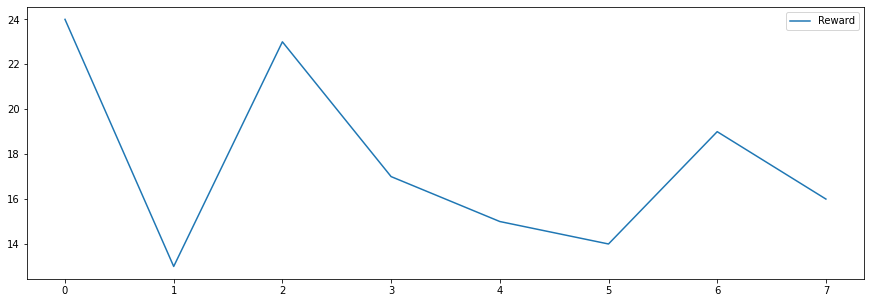

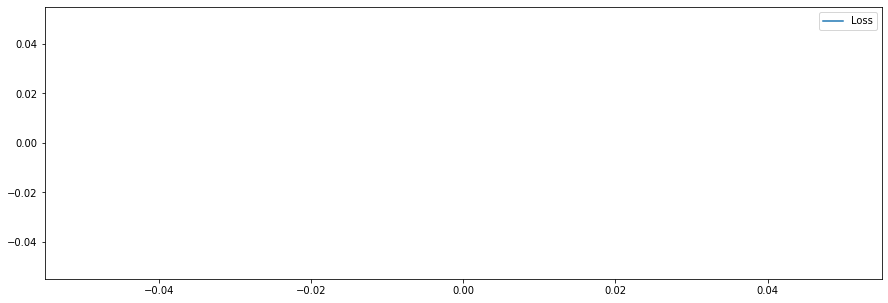

In [15]:
display_metrics(ppo_agent.rewards, "Reward")
display_metrics(ppo_agent.losses, "Loss", mov_avg=200)

In [34]:
env.close()

### Distributed Proximal Policy Optimisation